# 数据预处理
将数据从xls迁移到数据库

In [51]:
from algorithm import *
import pymysql
import pandas as pd
from sqlalchemy import create_engine

conf = {
    "host": "127.0.0.1",
    "username": "root",
    "password": "567321",
    "db": "WiLoc",
}

routers = {"00f3eb23":[5.55, 7.24], "00f403e9":[6.7, 0.94], "00f4041b":[1.65, 0.86]}

conn = pymysql.connect(host=conf['host'], user=conf['username'], password=conf['password'], charset="utf8")

In [52]:
# ! 重置数据库
conn.cursor().execute(f"DROP DATABASE IF EXISTS {conf['db']};")
conn.cursor().execute(f"CREATE DATABASE {conf['db']};")
conn.cursor().execute(f"USE {conf['db']};")

conn.cursor().execute("CREATE TABLE routers (router_id VARCHAR(10),\
    router_mac VARCHAR(20), A FLOAT, N FLOAT, x FLOAT, y FLOAT, \
    PRIMARY KEY (router_id));")

conn.cursor().execute("CREATE TABLE data (data_id INT AUTO_INCREMENT,\
    router_id VARCHAR(10), point_id INT, trace_id INT, time DATETIME,\
    phone_mac VARCHAR(20), rssi INT, raw_dist FLOAT, PRIMARY KEY(data_id),\
    FOREIGN KEY (router_id) REFERENCES routers(router_id) );")

conn.commit()

conn.close()

计算路由器的A和N

In [53]:
def get_mac_by_id(rid: str):
    rid = rid[2:4] + ':' + rid[4:6] + ':' + rid[6:8]
    return '14:6b:9c:'+rid

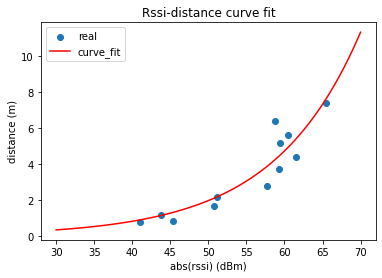

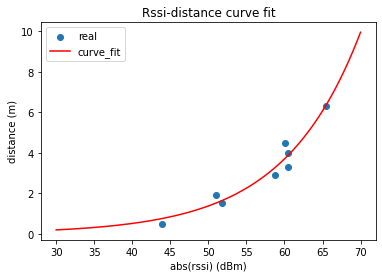

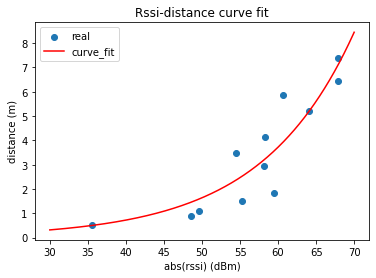

,router_id,router_mac,A,N,x,y
0,00f3eb23,14:6b:9c:f3:eb:23,42.202607,2.634876,5.55,7.24
1,00f403e9,14:6b:9c:f4:03:e9,46.805796,2.322619,6.70,0.94
2,00f4041b,14:6b:9c:f4:04:1b,43.972179,2.808067,1.65,0.86


In [54]:
AN_lst = []
for i in routers:
    A, N = fit_A_N("./data/"+ i +".xlsx")
    AN_lst.append({'router_id':i, 'router_mac':get_mac_by_id(i),\
                   'A':A, 'N':N, 'x':routers[i][0], 'y':routers[i][1]})
AN_lst = pd.DataFrame(AN_lst)
AN_lst

In [55]:
# TODO: AN_lst to sql
engine = create_engine(f"mysql+pymysql://{conf['username']}:{conf['password']}@{conf['host']}:3306/{conf['db']}?charset=utf8", encoding='utf-8')
AN_lst.to_sql('routers', engine, if_exists='append', index=False)

3

In [56]:
df_lst = read_data()

for i, df_point in enumerate(df_lst):
    df_point['point_id'] = i
    df_point['trace_id'] = 0
    df_point['router_id'] = df_point['router_id'].apply(str.strip)
    df_point['phone_mac'] = df_point['phone_mac'].apply(str.strip)
    df_point.rename(columns={'distance':'raw_dist', 'send_time':'time' }, inplace=True)
    df_point.drop(['latitude', 'longitude', 'router_mac'], axis=1, inplace=True)
    df_point['time'] = pd.to_datetime(df_point['time'])
    df_point.to_sql('data', engine, if_exists='append', index=False)



看看效果：

In [57]:
pd.read_sql('SELECT * FROM data WHERE point_id = 14', engine)

,data_id,router_id,point_id,trace_id,time,phone_mac,rssi,raw_dist
0,6182,00f3eb23,14,0,2023-05-01 18:39:13,d8:ce:3a:fa:9d:03,-55,4.2
1,6183,00f403e9,14,0,2023-05-01 18:39:14,d8:ce:3a:fa:9d:03,-49,2.5
2,6184,00f3eb23,14,0,2023-05-01 18:39:15,d8:ce:3a:fa:9d:03,-55,4.2
3,6185,00f4041b,14,0,2023-05-01 18:39:16,d8:ce:3a:fa:9d:03,-60,6.5
4,6186,00f403e9,14,0,2023-05-01 18:39:16,d8:ce:3a:fa:9d:03,-50,2.5
5,6187,00f4041b,14,0,2023-05-01 18:39:18,d8:ce:3a:fa:9d:03,-60,6.5
6,6192,00f403e9,14,0,2023-05-01 18:39:28,d8:ce:3a:fa:9d:03,-58,5.5
7,6195,00f403e9,14,0,2023-05-01 18:39:30,d8:ce:3a:fa:9d:03,-58,5.5
8,6198,00f4041b,14,0,2023-05-01 18:39:36,d8:ce:3a:fa:9d:03,-62,5.0
9,6199,00f3eb23,14,0,2023-05-01 18:39:37,d8:ce:3a:fa:9d:03,-61,9.1
